In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import h5py
import warnings
from prettytable import PrettyTable
from tqdm import tqdm

In [2]:
def load_data(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data']).transpose((0, 2, 3, 1))
    y_data = np.array(data['label'])
    return x_data, y_data

def evaluate_badnets(clean_data, poisoned_data, model):
    clean_x_test, clean_y_test = clean_data
    poisoned_x_test, poisoned_y_test = poisoned_data

    badnet_model = keras.models.load_model(model)

    clean_predictions = np.argmax(badnet_model.predict(clean_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(clean_predictions, clean_y_test)) * 100
    print('Clean Classification accuracy:', clean_accuracy)

    poisoned_predictions = np.argmax(badnet_model.predict(poisoned_x_test), axis=1)
    attack_success_rate = np.mean(np.equal(poisoned_predictions, poisoned_y_test)) * 100
    print('Attack Success Rate:', attack_success_rate)

In [32]:
def visualize_data(x_data, y_data, title):
    num_samples = 9
    selected_indices = np.random.randint(x_data.shape[0], size=num_samples)

    fig, axes = plt.subplots(3, 3, figsize=(10, 8))
    fig.suptitle(title)

    for i, ax in zip(selected_indices, axes.flatten()):
        img, label = x_data[i] / 255, y_data[i]
        ax.set_title(f"True Label: {label}")
        ax.axis("off")
        ax.imshow(img)

    plt.show()

In [45]:
# File paths
clean_data_file = 'valid.h5'
poisoned_data_file = 'bd_valid.h5'
original_badnet_model_file = 'bd_net.h5'
test_data_file = 'test.h5'
poisoned_test_data_file = 'bd_test.h5'

In [34]:
# Load and evaluate BadNets model
clean_data = load_data(clean_data_file)
poisoned_data = load_data(poisoned_data_file)
evaluate_badnets(clean_data, poisoned_data, original_badnet_model_file)

361/361 [==============================] - 4s 9ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 4s 10ms/step
Attack Success Rate: 100.0


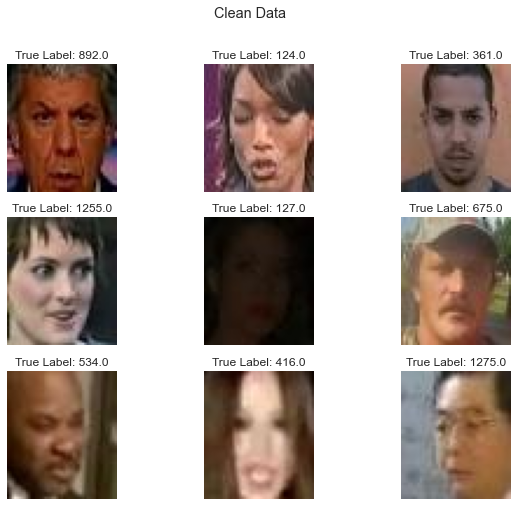

In [35]:
# Visualize clean and poisoned data
visualize_data(*clean_data, "Clean Data")

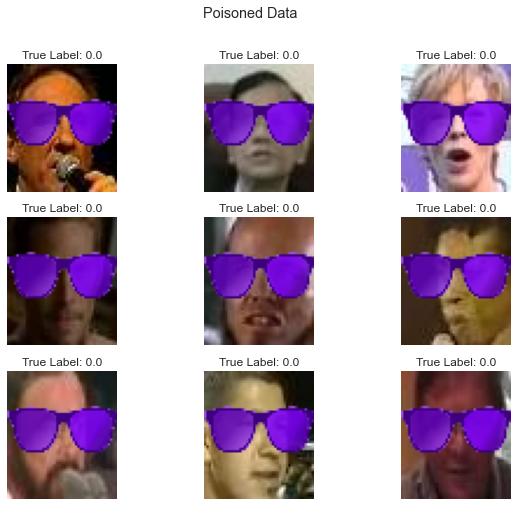

In [36]:
visualize_data(*poisoned_data, "Poisoned Data")

In [69]:
def prune_model(model_copy, channel_index, weight_matrix, bias_vector, clean_data_accuracy, saved_models, poisoned_data):
    # Set the specified channel weights and bias to zero
    weight_matrix[:, :, :, channel_index] = 0
    bias_vector[channel_index] = 0

    # Update the model's weights for the specified layer
    model_copy.layers[5].set_weights([weight_matrix, bias_vector])

    # Evaluate clean data accuracy
    clean_predictions = np.argmax(model_copy.predict(clean_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(clean_predictions, clean_y_test)) * 100

    # Evaluate attack success rate on poisoned data
    poisoned_predictions = np.argmax(model_copy.predict(poisoned_data[0]), axis=1)
    attack_success_rate = np.mean(np.equal(poisoned_predictions, poisoned_data[1])) * 100


    save_model_if_needed(clean_data_accuracy, clean_accuracy, model_copy, saved_models)

    return clean_accuracy, attack_success_rate

In [70]:
def save_model_if_needed(clean_data_accuracy, clean_accuracy, model_copy, saved_models):
    # Define the thresholds for accuracy drop
    thresholds = [2, 4, 10]

    # Iterate through the thresholds
    for i in range(len(thresholds)):
        threshold = thresholds[i]

        # Check if the accuracy drop exceeds the threshold and the model hasn't been saved yet
        if clean_data_accuracy - clean_accuracy >= threshold and not saved_models[i]:
            # Print a message indicating the accuracy drop and save the model
            print(f"The accuracy drops by {threshold}%, so saved the model")
            model_copy.save(f'{threshold}-Threshold-model.h5')

            # Mark the corresponding threshold as saved
            saved_models[i] = 1

In [71]:
# Pruning the model
clean_x_test, clean_y_test = clean_data
poisoned_x_test, poisoned_y_test = poisoned_data

clean_data_accuracy = 98.64899974019225
model_copy = keras.models.clone_model(keras.models.load_model(original_badnet_model_file))
model_copy.set_weights(keras.models.load_model(original_badnet_model_file).get_weights())
saved_models = np.zeros(3, dtype=bool)

# Getting the activation from the last pooling layer
layer_output = model_copy.get_layer('pool_3').output
intermediate_model = keras.models.Model(inputs=model_copy.input, outputs=layer_output)
intermediate_prediction = intermediate_model.predict(clean_x_test)
temp = np.mean(intermediate_prediction, axis=(0, 1, 2))
seq = np.argsort(temp)
weight_matrix = model_copy.layers[5].get_weights()[0]
bias_vector = model_copy.layers[5].get_weights()[1]

clean_accuracy_list = []
attack_success_rate_list = []

for i, channel_index in enumerate(tqdm(seq)):
    print(f"{i+1}/{len(seq)}", end=' ')
    clean_accuracy, attack_success_rate = prune_model(model_copy, channel_index, weight_matrix, bias_vector, clean_data_accuracy, saved_models, poisoned_data)
    clean_accuracy_list.append(clean_accuracy)
    attack_success_rate_list.append(attack_success_rate)
    print()
    print(f"Clean accuracy: {clean_accuracy}")
    print(f"Attack success rate: {attack_success_rate}")
    print(f"Pruned channel: {channel_index}")
    print()
    keras.backend.clear_session()

361/361 [==============================] - 2s 6ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 2s 7ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 0



  2%|▏         | 1/60 [00:06<06:21,  6.47s/it]

361/361 [==============================] - 3s 8ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 26



  3%|▎         | 2/60 [00:13<06:29,  6.71s/it]

361/361 [==============================] - 2s 7ms/step


  5%|▌         | 3/60 [00:20<06:29,  6.83s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 27

361/361 [==============================] - 3s 7ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 30



  7%|▋         | 4/60 [00:26<06:16,  6.73s/it]

361/361 [==============================] - 3s 8ms/step


  8%|▊         | 5/60 [00:35<06:43,  7.34s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 31

361/361 [==============================] - 3s 8ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 33



 10%|█         | 6/60 [00:42<06:29,  7.21s/it]

361/361 [==============================] - 3s 8ms/step


 12%|█▏        | 7/60 [00:49<06:28,  7.33s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 34

361/361 [==============================] - 3s 7ms/step


 13%|█▎        | 8/60 [00:56<06:13,  7.18s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 36

361/361 [==============================] - 3s 8ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 37



 15%|█▌        | 9/60 [01:03<06:05,  7.17s/it]

361/361 [==============================] - 3s 7ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 38



 17%|█▋        | 10/60 [01:10<05:51,  7.04s/it]

361/361 [==============================] - 3s 8ms/step


 18%|█▊        | 11/60 [01:17<05:49,  7.14s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 25

361/361 [==============================] - 3s 7ms/step


 20%|██        | 12/60 [01:24<05:38,  7.06s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 39

361/361 [==============================] - 3s 7ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 41



 22%|██▏       | 13/60 [01:31<05:26,  6.95s/it]

361/361 [==============================] - 3s 9ms/step

Clean accuracy: 98.64899974019225

 23%|██▎       | 14/60 [01:39<05:37,  7.33s/it]


Attack success rate: 100.0
Pruned channel: 44

361/361 [==============================] - 3s 7ms/step


 25%|██▌       | 15/60 [01:46<05:24,  7.21s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 45

361/361 [==============================] - 3s 8ms/step


 27%|██▋       | 16/60 [01:54<05:20,  7.29s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 47

361/361 [==============================] - 3s 8ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 48



 28%|██▊       | 17/60 [02:01<05:08,  7.18s/it]

361/361 [==============================] - 3s 8ms/step


 30%|███       | 18/60 [02:08<04:59,  7.13s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 49

361/361 [==============================] - 3s 7ms/step


 32%|███▏      | 19/60 [02:14<04:45,  6.95s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 50

361/361 [==============================] - 3s 9ms/step


 33%|███▎      | 20/60 [02:22<04:53,  7.34s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 53

361/361 [==============================] - 3s 7ms/step


 35%|███▌      | 21/60 [02:30<04:44,  7.30s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 55

361/361 [==============================] - 3s 9ms/step


 37%|███▋      | 22/60 [02:37<04:43,  7.46s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 40

361/361 [==============================] - 3s 8ms/step


 38%|███▊      | 23/60 [02:45<04:41,  7.61s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 24

361/361 [==============================] - 3s 7ms/step


 40%|████      | 24/60 [02:52<04:26,  7.41s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 59

361/361 [==============================] - 3s 8ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 9



 42%|████▏     | 25/60 [03:00<04:22,  7.49s/it]

361/361 [==============================] - 3s 8ms/step


 43%|████▎     | 26/60 [03:07<04:12,  7.43s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 2

361/361 [==============================] - 3s 7ms/step


 45%|████▌     | 27/60 [03:14<04:02,  7.34s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 12

361/361 [==============================] - 3s 8ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 13



 47%|████▋     | 28/60 [03:22<03:52,  7.27s/it]

361/361 [==============================] - 3s 9ms/step


 48%|████▊     | 29/60 [03:30<03:59,  7.73s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 17

361/361 [==============================] - 3s 7ms/step


 50%|█████     | 30/60 [03:37<03:45,  7.51s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 14

361/361 [==============================] - 3s 9ms/step

Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 15



 52%|█████▏    | 31/60 [03:45<03:40,  7.59s/it]

361/361 [==============================] - 3s 9ms/step


 53%|█████▎    | 32/60 [03:53<03:35,  7.71s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 23

361/361 [==============================] - 3s 9ms/step


 55%|█████▌    | 33/60 [04:00<03:24,  7.58s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 6

361/361 [==============================] - 3s 7ms/step

Clean accuracy: 98.64033948211657
Attack success rate: 100.0
Pruned channel: 51



 57%|█████▋    | 34/60 [04:07<03:11,  7.36s/it]

361/361 [==============================] - 3s 9ms/step


 58%|█████▊    | 35/60 [04:15<03:08,  7.53s/it]


Clean accuracy: 98.64033948211657
Attack success rate: 100.0
Pruned channel: 32

361/361 [==============================] - 3s 8ms/step


 60%|██████    | 36/60 [04:22<02:58,  7.43s/it]


Clean accuracy: 98.63167922404088
Attack success rate: 100.0
Pruned channel: 22

361/361 [==============================] - 3s 9ms/step

Clean accuracy: 98.65765999826795
Attack success rate: 100.0
Pruned channel: 21



 62%|██████▏   | 37/60 [04:30<02:53,  7.55s/it]

361/361 [==============================] - 3s 8ms/step


 63%|██████▎   | 38/60 [04:38<02:44,  7.49s/it]


Clean accuracy: 98.64899974019225
Attack success rate: 100.0
Pruned channel: 20

361/361 [==============================] - 3s 7ms/step


 65%|██████▌   | 39/60 [04:44<02:32,  7.28s/it]


Clean accuracy: 98.6056984498138
Attack success rate: 100.0
Pruned channel: 19

361/361 [==============================] - 3s 7ms/step

Clean accuracy: 98.57105741751104
Attack success rate: 100.0
Pruned channel: 43



 67%|██████▋   | 40/60 [04:52<02:25,  7.27s/it]

361/361 [==============================] - 3s 9ms/step


 68%|██████▊   | 41/60 [04:59<02:21,  7.44s/it]


Clean accuracy: 98.53641638520828
Attack success rate: 100.0
Pruned channel: 58

361/361 [==============================] - 3s 8ms/step

Clean accuracy: 98.19000606218066
Attack success rate: 100.0
Pruned channel: 3



 70%|███████   | 42/60 [05:07<02:16,  7.61s/it]

361/361 [==============================] - 3s 7ms/step


 72%|███████▏  | 43/60 [05:14<02:04,  7.32s/it]


Clean accuracy: 97.65307006148784
Attack success rate: 100.0
Pruned channel: 42

361/361 [==============================] - 3s 9ms/step

Clean accuracy: 97.50584567420108
Attack success rate: 100.0
Pruned channel: 1



 73%|███████▎  | 44/60 [05:22<01:58,  7.41s/it]

361/361 [==============================] - 3s 7ms/step
The accuracy drops by 2%, so saved the model


 75%|███████▌  | 45/60 [05:29<01:50,  7.34s/it]


Clean accuracy: 95.75647354291158
Attack success rate: 100.0
Pruned channel: 29

361/361 [==============================] - 3s 9ms/step


 77%|███████▋  | 46/60 [05:36<01:43,  7.38s/it]


Clean accuracy: 95.20221702606739
Attack success rate: 99.9913397419243
Pruned channel: 16

361/361 [==============================] - 3s 8ms/step


 78%|███████▊  | 47/60 [05:43<01:34,  7.28s/it]


Clean accuracy: 94.7172425738287
Attack success rate: 99.9913397419243
Pruned channel: 56

361/361 [==============================] - 3s 8ms/step
The accuracy drops by 4%, so saved the model


 80%|████████  | 48/60 [05:50<01:26,  7.20s/it]


Clean accuracy: 92.09318437689443
Attack success rate: 99.9913397419243
Pruned channel: 46

361/361 [==============================] - 3s 7ms/step

Clean accuracy: 91.49562656967177
Attack success rate: 99.9913397419243
Pruned channel: 5



 82%|████████▏ | 49/60 [05:57<01:18,  7.12s/it]

361/361 [==============================] - 3s 9ms/step


 83%|████████▎ | 50/60 [06:05<01:13,  7.33s/it]


Clean accuracy: 91.01931237550879
Attack success rate: 99.98267948384861
Pruned channel: 8

361/361 [==============================] - 3s 8ms/step


 85%|████████▌ | 51/60 [06:13<01:06,  7.44s/it]


Clean accuracy: 89.17467740538669
Attack success rate: 80.73958603966398
Pruned channel: 11

361/361 [==============================] - 3s 7ms/step
The accuracy drops by 10%, so saved the model


 87%|████████▋ | 52/60 [06:20<00:58,  7.32s/it]


Clean accuracy: 84.43751623798389
Attack success rate: 77.015675067117
Pruned channel: 54

361/361 [==============================] - 3s 8ms/step


 88%|████████▊ | 53/60 [06:30<00:56,  8.04s/it]


Clean accuracy: 76.48739932449988
Attack success rate: 35.71490430414826
Pruned channel: 10

361/361 [==============================] - 3s 7ms/step

Clean accuracy: 54.8627349095003
Attack success rate: 6.954187234779596
Pruned channel: 28



 90%|█████████ | 54/60 [06:36<00:45,  7.67s/it]

361/361 [==============================] - 3s 7ms/step

Clean accuracy: 27.08928726076037
Attack success rate: 0.4243526457088421
Pruned channel: 35



 92%|█████████▏| 55/60 [06:43<00:37,  7.47s/it]

361/361 [==============================] - 3s 8ms/step


 93%|█████████▎| 56/60 [06:50<00:29,  7.34s/it]


Clean accuracy: 13.87373343725643
Attack success rate: 0.0
Pruned channel: 18

361/361 [==============================] - 3s 10ms/step


 95%|█████████▌| 57/60 [06:59<00:23,  7.70s/it]


Clean accuracy: 7.101411622066338
Attack success rate: 0.0
Pruned channel: 4

361/361 [==============================] - 3s 9ms/step


 97%|█████████▋| 58/60 [07:09<00:16,  8.42s/it]


Clean accuracy: 1.5501861955486274
Attack success rate: 0.0
Pruned channel: 7

361/361 [==============================] - 5s 13ms/step


 98%|█████████▊| 59/60 [07:22<00:09,  9.72s/it]


Clean accuracy: 0.7188014202823244
Attack success rate: 0.0
Pruned channel: 52

361/361 [==============================] - 4s 11ms/step


100%|██████████| 60/60 [07:32<00:00,  7.55s/it]


Clean accuracy: 0.0779423226812159
Attack success rate: 0.0
Pruned channel: 57



In [88]:
print("Clean Accuracy:")
print(clean_accuracy_list)
print("Attack Success Rate:")    
print(attack_success_rate_list)

Clean Accuracy:
[98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.4375162379838

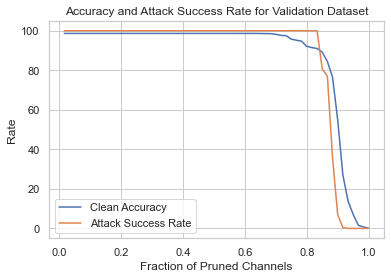

In [73]:
x_axis = np.arange(1, 61) / 60

# Create a DataFrame with the data
data = {
    'Fraction of Pruned Channels': x_axis,
    'Clean Accuracy': clean_accuracy_list,
    'Attack Success Rate': attack_success_rate_list
}
df = pd.DataFrame(data)

# Set Seaborn style to white grid
sns.set(style="whitegrid")

# Use Seaborn to plot
sns.lineplot(x='Fraction of Pruned Channels', y='Clean Accuracy', data=df, label='Clean Accuracy')
sns.lineplot(x='Fraction of Pruned Channels', y='Attack Success Rate', data=df, label='Attack Success Rate')

# Set labels and title
plt.xlabel("Fraction of Pruned Channels")
plt.ylabel("Rate")
plt.title("Accuracy and Attack Success Rate for Validation Dataset")

# Show legend
plt.legend()

# Show the plot
plt.show()

In [74]:
index = np.where(np.array(clean_accuracy_list) <= (clean_data_accuracy - 15))[0]
print("Attack success rate when the accuracy drops at least 15%: ", attack_success_rate_list[index[0]])

Attack success rate when the accuracy drops at least 15%:  35.71490430414826


In [60]:
class GoodNet(keras.Model):
    def __init__(self, original_model, repaired_model):
        """
        Constructor for the GoodNet class.

        Parameters:
            original_model (keras.Model): The original (bad) model.
            repaired_model (keras.Model): The repaired (good) model.
        """
        super(GoodNet, self).__init__()
        self.original_model = original_model
        self.repaired_model = repaired_model

    def predict(self, data):
        """
        Make predictions using both the original and repaired models.

        Parameters:
            data (numpy.ndarray): Input data for making predictions.

        Returns:
            numpy.ndarray: Predictions based on the comparison between original and repaired models.
        """
        # Get predictions from the original model
        y = np.argmax(self.original_model(data), axis=1)

        # Get predictions from the repaired model
        y_prime = np.argmax(self.repaired_model(data), axis=1)

        # Use original predictions where they match, otherwise use a placeholder value (1283)
        pred = np.where(y == y_prime, y, 1283)
        return pred

In [75]:
# Define the filenames
clean_data_filename = 'test.h5'
poisoned_data_filename = 'bd_test.h5'
model_2_filename = '2-Threshold-model.h5'
model_4_filename = '4-Threshold-model.h5'
model_10_filename = '10-Threshold-model.h5'

# Load the test models
model_2 = keras.models.load_model(model_2_filename)
model_4 = keras.models.load_model(model_4_filename)
model_10 = keras.models.load_model(model_10_filename)

# Load test data
x_clean_data, y_clean_data = load_data(clean_data_filename)
x_test_poisoned_data, y_poisoned_data = load_data(poisoned_data_filename)

# Print data shapes
print("x_clean_data shape:", x_clean_data.shape)
print("x_test_poisoned data shape:", x_test_poisoned_data.shape)

x_clean_data shape: (12830, 55, 47, 3)
x_test_poisoned data shape: (12830, 55, 47, 3)


In [76]:
# Load the original badnet model
model = keras.models.load_model(original_badnet_model_file)

# Create GoodNet models
goodnet_model_2 = GoodNet(model, model_2)
goodnet_model_4 = GoodNet(model, model_4)
goodnet_model_10 = GoodNet(model, model_10)

In [77]:
def evaluate_model_performance(model, test_data, poisoned_test_data, drop_percentage):
    cl_test_label_p = np.argmax(model.predict(test_data), axis=1)
    clean_test_accuracy = np.mean(np.equal(cl_test_label_p, y_test_data)) * 100
    print(f'{drop_percentage}% drops - clean test data Classification accuracy:', clean_test_accuracy)

    bd_test_label_p = np.argmax(model.predict(poisoned_test_data), axis=1)
    attack_success_rate = np.mean(np.equal(bd_test_label_p, y_test_poisoned_data)) * 100
    print(f'{drop_percentage}% drops Attack Success Rate:', attack_success_rate)

    return clean_test_accuracy, attack_success_rate

# Evaluate performance for different drop percentages and save outputs
eval_2_acc, eval_2_asr = evaluate_model_performance(model_2, x_clean_data, x_test_poisoned_data, 2)
eval_4_acc, eval_4_asr = evaluate_model_performance(model_4, x_clean_data, x_test_poisoned_data, 4)
eval_10_acc, eval_10_asr = evaluate_model_performance(model_10, x_clean_data, x_test_poisoned_data, 10)


401/401 [==============================] - 3s 8ms/step
2% drops - clean test data Classification accuracy: 95.90023382696803
401/401 [==============================] - 3s 7ms/step
2% drops Attack Success Rate: 100.0
401/401 [==============================] - 3s 7ms/step
4% drops - clean test data Classification accuracy: 92.29150428682775
401/401 [==============================] - 3s 8ms/step
4% drops Attack Success Rate: 99.98441153546376
401/401 [==============================] - 3s 8ms/step
10% drops - clean test data Classification accuracy: 84.54403741231489
401/401 [==============================] - 3s 8ms/step
10% drops Attack Success Rate: 77.20966484801247


In [78]:
eval_acc_list = [eval_2_acc, eval_4_acc, eval_10_acc]
eval_asr_list = [eval_2_asr, eval_4_asr, eval_10_asr]

table = PrettyTable()
table.field_names = ["Model", "Clean Test Accuracy", "Attack Success Rate"]

for model, acc, asr in zip(["2%-Repair", "4%-Repair", "10%-Repair"], eval_acc_list, eval_asr_list):
    table.add_row([model, acc, asr])

print(table)

+------------+---------------------+---------------------+
|   Model    | Clean Test Accuracy | Attack Success Rate |
+------------+---------------------+---------------------+
| 2%-Repair  |  95.90023382696803  |        100.0        |
| 4%-Repair  |  92.29150428682775  |  99.98441153546376  |
| 10%-Repair |  84.54403741231489  |  77.20966484801247  |
+------------+---------------------+---------------------+


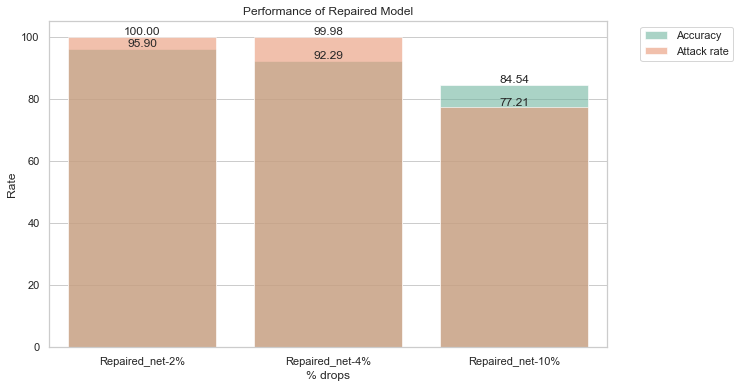

In [81]:
sns.set(
    style="whitegrid",
    palette="viridis",
)

# Define bar properties with random values
opacity = 0.6
bar_width = 0.4

# Data
data = {
    "text_acc": eval_acc_list,
    "attack_rate": eval_asr_list,
    "model": ["Repaired_net-2%", "Repaired_net-4%", "Repaired_net-10%"]
}
df = pd.DataFrame(data)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create Seaborn bar plot
bar_plot = sns.barplot(x='model', y='text_acc', data=df, color='#66c2a5', alpha=opacity, label='Accuracy')
sns.barplot(x='model', y='attack_rate', data=df, color='#fc8d62', alpha=opacity, label='Attack rate')

# Add counts above the bars
for p in bar_plot.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('% drops')
plt.ylabel('Rate')
plt.title('Performance of Repaired Model')

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [83]:
def calculate_combined_metrics_and_print(G_model, x_clean_data, y_clean_data, x_poisoned_data, y_poisoned_data, model_name):
    cl_test_label_p = G_model.predict(x_clean_data)
    clean_test_accuracy = np.mean(np.equal(cl_test_label_p, y_clean_data)) * 100

    bd_test_label_p = G_model.predict(x_poisoned_data)
    attack_success_rate = np.mean(np.equal(bd_test_label_p, y_poisoned_data)) * 100

    print(f'Combined {model_name} drops model, the clean test data Classification accuracy:', clean_test_accuracy)
    print(f'Combined {model_name} drops model, Attack Success Rate:', attack_success_rate)

    return clean_test_accuracy, attack_success_rate


# Calculate metrics for goodnet_model_2
G_clean_test_2_accuracy, G_asr_2 = calculate_combined_metrics_and_print(goodnet_model_2, x_clean_data, y_clean_data,
                                                                      x_test_poisoned_data, y_poisoned_data, '2%')
# Calculate metrics for goodnet_model_4
G_clean_test_4_accuracy, G_asr_4 = calculate_combined_metrics_and_print(goodnet_model_4, x_clean_data, y_clean_data,
                                                                      x_test_poisoned_data, y_poisoned_data, '4%')
# Calculate metrics for goodnet_model_10
G_clean_test_10_accuracy, G_asr_10 = calculate_combined_metrics_and_print(goodnet_model_10, x_clean_data, y_clean_data,x_test_poisoned_data, y_poisoned_data, '10%')


Combined 2% drops model, the clean test data Classification accuracy: 95.74434918160561
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, the clean test data Classification accuracy: 92.1278254091972
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, the clean test data Classification accuracy: 84.3335931410756
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [85]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]

G_table = PrettyTable()
G_table.field_names = ["G_Model", "G_Clean Test Accuracy", "G_Attack Success Rate"]

for model, acc, asr in zip(["G-2%-Repair", "G-4%-Repair", "G-10%-Repair"], G_test_acc, G_attack_rate):
    G_table.add_row([model, acc, asr])

print(G_table)

+--------------+-----------------------+-----------------------+
|   G_Model    | G_Clean Test Accuracy | G_Attack Success Rate |
+--------------+-----------------------+-----------------------+
| G-2%-Repair  |   95.74434918160561   |         100.0         |
| G-4%-Repair  |    92.1278254091972   |   99.98441153546376   |
| G-10%-Repair |    84.3335931410756   |   77.20966484801247   |
+--------------+-----------------------+-----------------------+


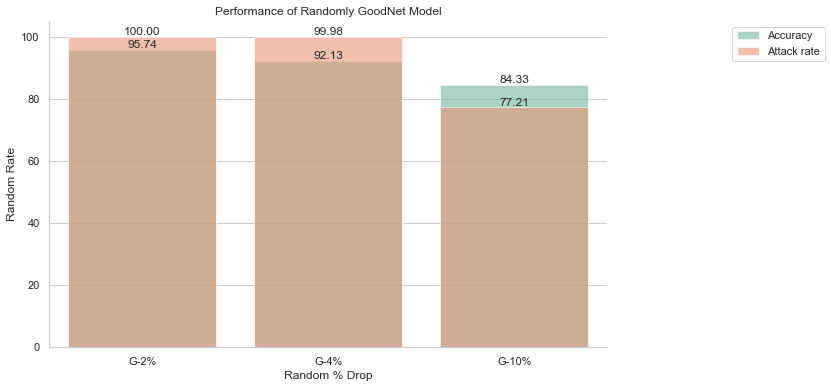

In [86]:
sns.set(
    style="whitegrid",
    palette="viridis",
    )

# Define bar properties with random values
opacity = 0.6
bar_width = 0.4

# Create a DataFrame for G_model metrics
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G-2%", "G-4%", "G-10%"]
}
G_df = pd.DataFrame(G_data)

# Plot the data using Seaborn with random colors
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=G_df, x="G_model", y="G_text_acc", color='#66c2a5', alpha=opacity, label='Accuracy')
barplot = sns.barplot(data=G_df, x="G_model", y="G_attack_rate", color='#fc8d62', alpha=opacity, label='Attack rate')

# Add counts above the two bar graphs
for rect in barplot.patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

# Customize the plot with random labels and title
plt.xlabel('Random % Drop')
plt.ylabel('Random Rate')
plt.title('Performance of Randomly GoodNet Model')
plt.legend(bbox_to_anchor=(1.4, 1))
sns.despine()

# Show the plot
plt.show()